<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/08-SuperResolution_StyleTransfer/FastNeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Neural Style Transfer
https://github.com/pytorch/examples/tree/6c8e2bab4d45f2386929c83bb4480c18d2b660fd/fast_neural_style

In [81]:
import gdown

Download the saved models

In [83]:
gdown.download('https://drive.google.com/uc?id=1N8rxqDAU7y1fBVpuD-ZQdEvjyJRCn1K2', 'fst_saved_models.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1N8rxqDAU7y1fBVpuD-ZQdEvjyJRCn1K2
To: /content/fst_saved_models.zip
25.0MB [00:00, 181MB/s]


'fst_saved_models.zip'

In [84]:
! unzip fst_saved_models.zip

Archive:  fst_saved_models.zip
   creating: saved_models/
  inflating: saved_models/candy.pth  
  inflating: saved_models/mosaic.pth  
  inflating: saved_models/rain_princess.pth  
  inflating: saved_models/udnie.pth  


In [67]:
import torch

class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=float(self.upsample))
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [68]:
from PIL import Image
import re
import torchvision.transforms as T

Give some sample image

In [113]:
content_image = Image.open('/content/Snapchat-7688427-01.jpeg')

In [114]:
content_image.size

(935, 1280)

Resize the image if either the height or the width exceeds 500

In [115]:
larger_side = content_image.size[0] if content_image.size[0] > content_image.size[1] else content_image.size[1]
if larger_side > 500 :
    scale = larger_side / 500
else:
    scale = 1.0
scale

2.56

In [116]:
content_image = content_image.resize((int(content_image.size[0] / scale), int(content_image.size[1] / scale)), Image.ANTIALIAS)
content_image.size

(365, 500)

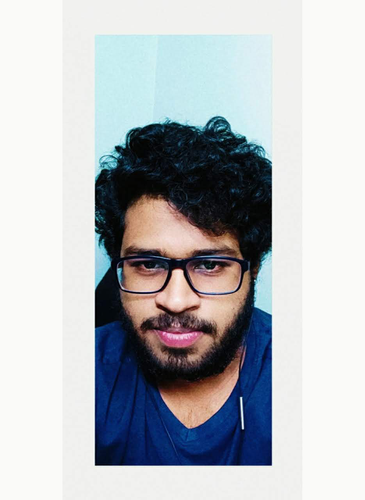

In [117]:
content_image

In [118]:
content_transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.mul(255))
])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0)

In [74]:
with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load('saved_models/mosaic.pth')
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)

    output = style_model(content_image)

In [75]:
output = output.squeeze(0)

In [76]:
out = output.permute(1, 2, 0).cpu().clamp(0, 255).numpy()

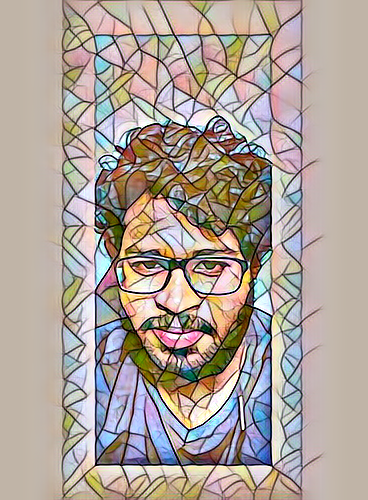

In [77]:
Image.fromarray(out.astype("uint8"))

## Test a Scripted Model

In [ ]:
scripted_model = torch.jit.script(style_model)

In [79]:
with torch.no_grad():
    output = style_model(content_image)

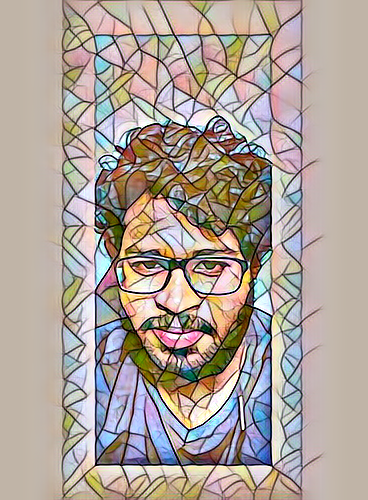

In [80]:
Image.fromarray(output.squeeze(0).cpu().permute(1, 2, 0).clamp(0, 255).numpy().astype('uint8'))

## Save the Scripted Models

In [93]:
from pathlib import Path

In [104]:
root = Path('saved_models')
models = ['candy.pth', 'mosaic.pth', 'rain_princess.pth', 'udnie.pth']
out_model = Path('fst_models_scripted')
out_model.mkdir(parents=True, exist_ok=True)

In [106]:
for model in models:
    m_path = root / model

    style_model = TransformerNet()
    state_dict = torch.load(m_path)
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    scripted_model = torch.jit.script(style_model)
    print(f'=> saving {m_path.stem}')
    scripted_model.save(str(out_model / f'{m_path.stem}.scripted.pt'))

=> saving candy
=> saving mosaic
=> saving rain_princess
=> saving udnie


In [107]:
scripted_models = Path('fst_models_scripted')

In [121]:
out_images = []
for model in scripted_models.iterdir():
    model = torch.jit.load(str(model))
    with torch.no_grad():
        output = model(content_image)
    out_images.append(output.squeeze(0).cpu().permute(1, 2, 0).clamp(0, 255).numpy().astype('uint8'))

In [122]:
import numpy as np

In [127]:
images_combined = np.hstack([np.asarray(img) for img in out_images])

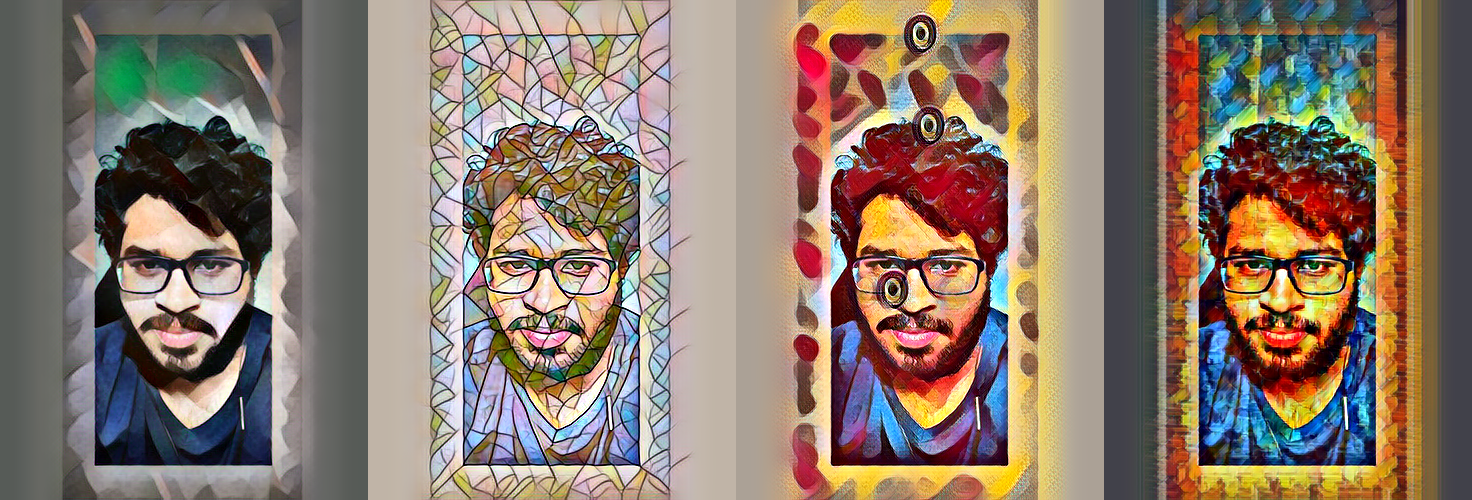

In [126]:
Image.fromarray(images_combined)

In [128]:
! zip -r fst_models_scripted.zip fst_models_scripted

  adding: fst_models_scripted/ (stored 0%)
  adding: fst_models_scripted/udnie.scripted.pt (deflated 7%)
  adding: fst_models_scripted/mosaic.scripted.pt (deflated 7%)
  adding: fst_models_scripted/candy.scripted.pt (deflated 7%)
  adding: fst_models_scripted/rain_princess.scripted.pt (deflated 7%)
